In [1]:
import pandas as pd
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

In [ ]:
class DailyVolatilityFactors:
    def __init__(self, df):
        self.raw_df = df.copy()
        self.daily_df = None  # daily data & factor

    def preprocess_data(self):
        self.raw_df['time'] = pd.to_datetime(self.raw_df['time'])
        self.raw_df['time'] = self.raw_df['time'].dt.tz_convert('Asia/Hong_Kong')
        self.raw_df['date'] = self.raw_df['time'].dt.date
        self.raw_df = self.raw_df.sort_values('time')
        self.raw_df['return'] = np.log(self.raw_df['close']/self.raw_df['close'].shift(1))
        self.raw_df['prev_close'] = self.raw_df['close'].shift(1)
        self.raw_df['TR'] = self.raw_df.apply(
            lambda x: max(x['high'] - x['low'],
                         abs(x['high'] - x['prev_close']),
                         abs(x['low'] - x['prev_close'])), axis=1)
        self.raw_df['rhclose'] = ((self.raw_df['high'] - self.raw_df['close']) / (self.raw_df['high'] - self.raw_df['low'])).expanding().apply(lambda x: (x <= x.iloc[-1]).mean())
        self.raw_df['rlclose'] = ((self.raw_df['close'] - self.raw_df['low']) / (self.raw_df['high'] - self.raw_df['low'])).expanding().apply(lambda x: (x <= x.iloc[-1]).mean())
        self.raw_df['rclosent'] = self.raw_df['rhclose'] * self.raw_df['rlclose']
        self.raw_df['2diff'] = np.power(self.raw_df['close'] - self.raw_df['open'], 2).expanding().apply(lambda x: (x <= x.iloc[-1]).mean())

    def calculate_factors(self):
        grouped = self.raw_df.groupby('date')
        self.daily_df = pd.DataFrame(index=grouped.groups.keys())
        self.daily_df.index.name = 'date'
        self.daily_df.index = pd.to_datetime(self.daily_df.index)

        self.daily_df['Realized_Vol'] = grouped['return'].apply(lambda x: np.sqrt(np.sum(x**2)))
        self.daily_df['Daily_Range'] = grouped.apply(lambda x: x['high'].max() - x['low'].min())
        self.daily_df['Abs_Return_Sum'] = grouped['return'].apply(lambda x: np.abs(x).sum())

        self.daily_df['Intraday_Skewness'] = grouped.apply(lambda x: x['close'].pct_change().skew())
        self.daily_df['Intraday_Kurtosis'] = grouped.apply(lambda x: x['close'].pct_change().kurtosis())
    
        self.daily_df['High_Low_Quantile_Range'] = grouped.apply(lambda x: x['high'].quantile(0.75) - x['low'].quantile(0.25))
        
        self.daily_df['Parkinson_Vol'] = grouped.apply(lambda x: np.sqrt(np.nansum((np.log(x['high']/x['low'])**2))/(4*len(x)*np.log(2))))
        self.daily_df['Volatility_Efficiency'] = self.daily_df['Realized_Vol'] / (self.daily_df['Daily_Range'] + 1e-6)
       
        self.daily_df['Positive_SemiVol'] = grouped.apply(lambda x: np.sqrt(np.sum(x['return'][x['return']>0]**2)))
        self.daily_df['Negative_SemiVol'] = grouped.apply(lambda x: np.sqrt(np.sum(x['return'][x['return']<0]**2)))

        def overnight_jump(group):
            try:
                prev_close = group['close'].iloc[-1]  
                next_open = group['open'].iloc[0]   
                return np.log(next_open/prev_close)
            except:
                return np.nan
        self.daily_df['Overnight_Jump'] = grouped.apply(overnight_jump).shift(1)

        morning_start = pd.to_datetime('09:15').time()
        morning_end = pd.to_datetime('12:00').time()
        afternoon_start = pd.to_datetime('13:00').time()
        afternoon_end = pd.to_datetime('16:30').time()
     
        morning_mask = (self.raw_df['time'].dt.time >= morning_start) & (self.raw_df['time'].dt.time <= morning_end)
        morning_group = self.raw_df[morning_mask].groupby('date')
        self.daily_df['Morning_Vol'] = morning_group.apply(
            lambda x: np.sqrt(np.sum(np.log(x['close']/x['close'].shift(1)).dropna()**2)))
    
        afternoon_mask = (self.raw_df['time'].dt.time >= afternoon_start) & (self.raw_df['time'].dt.time <= afternoon_end)
        afternoon_group = self.raw_df[afternoon_mask].groupby('date')
        self.daily_df['Afternoon_Vol'] = afternoon_group.apply(
            lambda x: np.sqrt(np.sum(np.log(x['close']/x['close'].shift(1)).dropna()**2)))

        tail_end = self.raw_df.groupby('date')['time'].max() 
        tail_mask = self.raw_df['time'].isin(tail_end - pd.Timedelta(minutes=30))
        tail_group = self.raw_df[tail_mask].groupby('date')
        self.daily_df['Tail_Vol'] = tail_group.apply(lambda x: np.sqrt(np.sum(np.log(x['close']/x['close'].shift(1)).dropna()**2)))

        self.daily_df['next_vol'] = grouped.apply(lambda x: np.sqrt(np.sum(np.log(x['close']/x['close'].shift(1)).dropna()**2)))

        self.daily_df['Avg_TR'] = grouped['TR'].mean()
        
        self.daily_df['monotonic'] = grouped['rclosent'].mean()
        self.daily_df['2diff'] = grouped['2diff'].mean()

        def count_jumps(group):
            returns = np.log(group['close']).diff().dropna()
            threshold = 2 * returns.std()
            return (np.abs(returns) > threshold).sum()
        self.daily_df['Jump_Count'] = grouped.apply(count_jumps)

        self.daily_df['Max_Jump'] = grouped.apply(lambda x: np.log(x['close']).diff().abs().max())

        n = 10
        tp = grouped.apply(lambda x: np.nansum(x['high'] + x['low'] + x['close']) / 3)
        ma_tp = tp.rolling(n).mean()
        mad_tp = tp.rolling(n).apply(lambda x: np.mean(np.abs(x - np.mean(x))))
        self.daily_df['CCI'] = (tp - ma_tp) / (0.015 * mad_tp)

        def vol_rsi(group):
            returns = np.log(group['close']).diff().dropna()
            up_days = returns[returns > 0].std()
            down_days = returns[returns < 0].std() * -1
            return up_days / (up_days + down_days + 1e-6)
        self.daily_df['Vol_RSI'] = grouped.apply(vol_rsi)
    
        
    def postprocess(self):
        self.daily_df = self.daily_df.dropna()
        self.daily_df = self.daily_df.sort_index()

    def get_factors(self):
        self.preprocess_data()
        self.calculate_factors()
        self.postprocess()
        return self.daily_df

In [ ]:
def get_csv_files(directory):
    csv_files = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            csv_files.append(os.path.join(directory, file))
    return csv_files

directory_path = r'C:\Users\sameu\Desktop\JPMcapstone-main' # change to your directory 
csv_files = get_csv_files(os.path.join(directory_path,'data'))

In [ ]:
file = csv_files[3]
raw_df = pd.read_csv(file)
test_factors = DailyVolatilityFactors(raw_df)
test_factors.get_factors().to_csv(os.path.join(directory_path, 'factor', file.split('\\')[-1]))

In [5]:
'''
for file in csv_files:
    raw_df = pd.read_csv(file)
    test_factors = DailyVolatilityFactors(raw_df)
    test_factors.get_factors().to_csv('JPMcapstone/vol_factors/'+file.split('/')[-1])
'''

"\nfor file in csv_files:\n    raw_df = pd.read_csv(file)\n    test_factors = DailyVolatilityFactors(raw_df)\n    test_factors.get_factors().to_csv('JPMcapstone/vol_factors/'+file.split('/')[-1])\n"

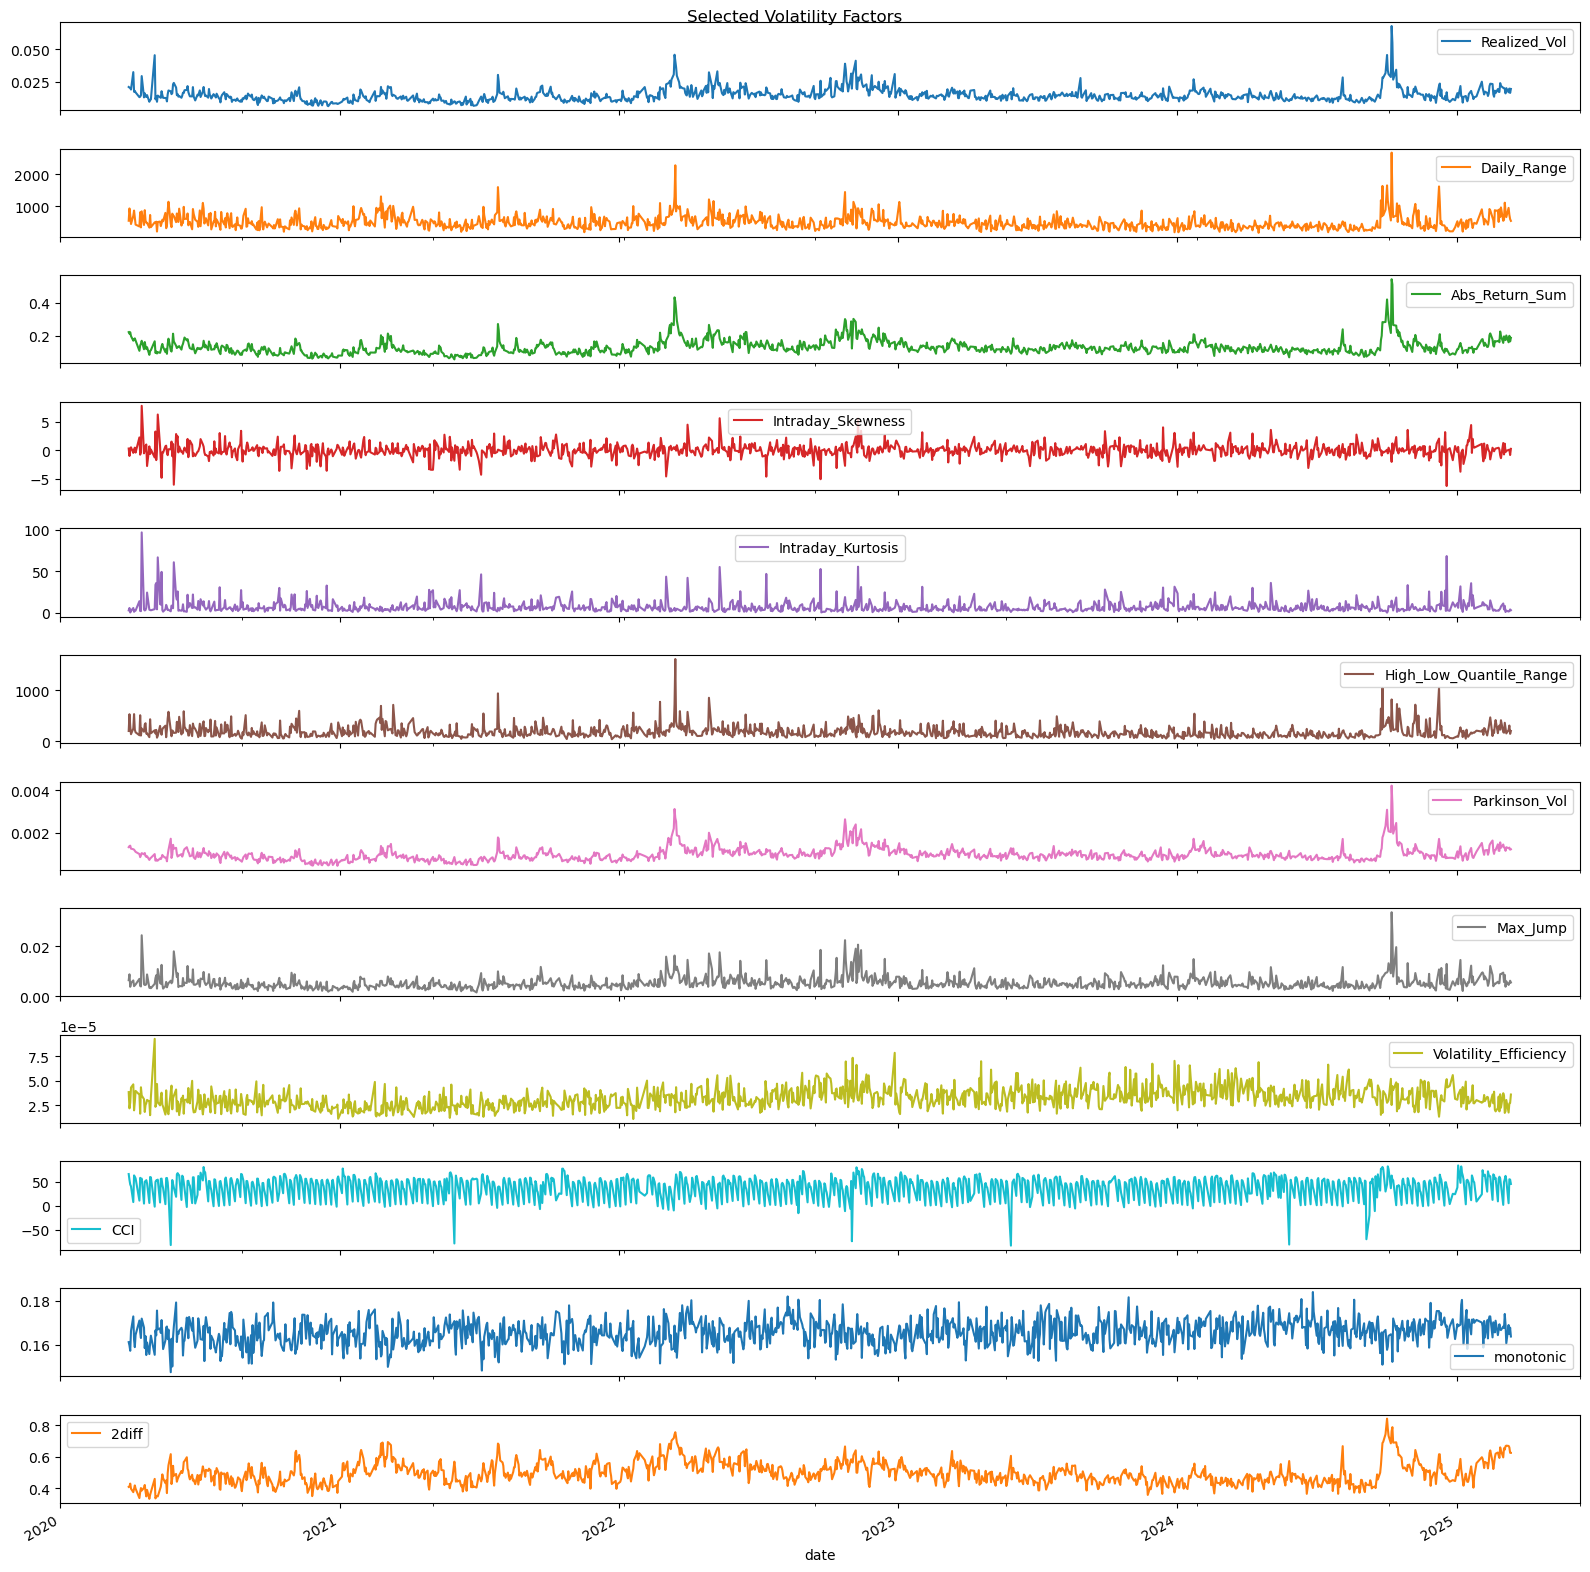

In [6]:
import matplotlib.pyplot as plt
daily_factors = test_factors.get_factors()
daily_factors[['Realized_Vol', 'Daily_Range', 'Abs_Return_Sum', 'Intraday_Skewness','Intraday_Kurtosis','High_Low_Quantile_Range','Parkinson_Vol','Max_Jump', 'Volatility_Efficiency', 'CCI', 'monotonic', '2diff']].plot(
    subplots=True,
    figsize=(16,16),
    title='Selected Volatility Factors'
)
plt.tight_layout()

In [22]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

data_set = test_factors.daily_df.copy()
data_set.replace([np.inf, -np.inf], np.nan, inplace=True)
data_set.ffill(inplace=True)
data_set.dropna(inplace=True)

# Train test split 
split_index = int(len(data_set) * 0.8)
train_data = data_set.iloc[:split_index]
test_data = data_set.iloc[split_index:]

# Features & Target 
features = [
    'Realized_Vol', 'Daily_Range', 'Abs_Return_Sum',
    'Intraday_Skewness', 'Intraday_Kurtosis', 'High_Low_Quantile_Range',
    'Parkinson_Vol', 'Max_Jump', 'Volatility_Efficiency',
    'CCI', 'monotonic', '2diff'
]
target = 'next_vol'

X_train = train_data[features].copy()
y_train = train_data[target].copy()
X_test = test_data[features].copy()
y_test = test_data[target].copy()

# 2. Scaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3. Get alpha
tscv = TimeSeriesSplit(n_splits=5)

lasso_cv = RidgeCV( #LassoCV(
    cv=tscv, 
    # random_state=42, 
    # max_iter=10000  
)
lasso_cv.fit(X_train_scaled, y_train)


# 4. Predict 
y_pred = lasso_cv.predict(X_test_scaled)

# 5. MSE & R^2 
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

MSE: 3.768650434095078e-05
R^2: 0.3332958741569224
